In [0]:
!mkdir results
!pip install keras

In [1]:
!wget https://github.com/AISaturdaysTaipei/fastai/blob/master/images/bird.png  

--2018-03-04 01:43:26--  https://github.com/AISaturdaysTaipei/fastai/blob/master/images/bird.png
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘bird.png’

bird.png                [ <=>                ]  31.79K  --.-KB/s    in 0.01s   

2018-03-04 01:43:26 (2.32 MB/s) - ‘bird.png’ saved [32555]



In [2]:
!wget https://github.com/AISaturdaysTaipei/fastai/blob/master/images/starry-night.png

--2018-03-04 01:43:32--  https://github.com/AISaturdaysTaipei/fastai/blob/master/images/starry-night.png
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘starry-night.png’

starry-night.png        [ <=>                ]  31.89K  --.-KB/s    in 0.01s   

2018-03-04 01:43:32 (2.36 MB/s) - ‘starry-night.png’ saved [32651]



In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fmin_l_bfgs_b

from scipy.misc import imsave  # `imsave` is deprecated! Use `imageio.imwrite`ß instead.
# from imageio import imwrite

import time
from keras.preprocessing.image import load_img, img_to_array 
from keras import backend as K
from keras import metrics
from keras.models import Model
from keras.applications import vgg16

Using TensorFlow backend.


Original content image


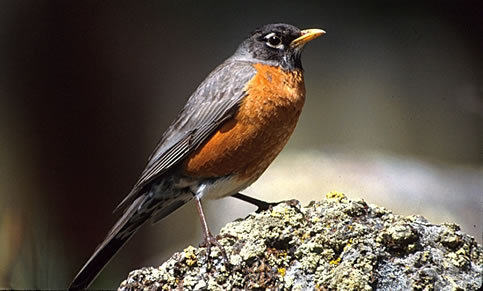

In [0]:
# This is the path to the image you want to transform.
content_img_path = 'bird.png'
# This is the path to the style image.
style_image_path = 'starry-night.png'

original_img = load_img(content_img_path)
width, height = original_img.size

print('Original content image')
original_img

Original Style image


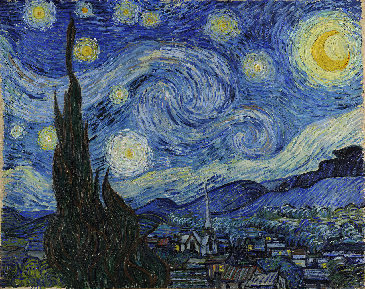

In [0]:
print('Original Style image')
load_img(style_image_path)

Resized content image


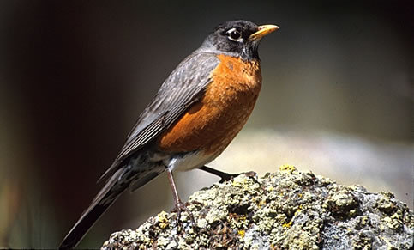

In [0]:
# 設定image的大小
img_height = 250

img_width = int(width * img_height / height)

resized_img = original_img.resize((img_width, img_height))

print('Resized content image')
resized_img

In [0]:
# 預處理image，得到image_arr, shape=(1,img_height, img_width, 3)
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_arr = img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = vgg16.preprocess_input(img_arr)
    return img_arr


# image送進vgg16之前要先normalize
# deprocess_image用來還原經過normalize的image
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x = x.copy()
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Content Reconstructions

In [0]:
model = vgg16.VGG16(include_top=False)
print('Model loaded.')

Model loaded.


In [0]:
content_img_arr = preprocess_image(content_img_path)
style_image_arr = preprocess_image(style_image_path)
shp = content_img_arr.shape

In [0]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)
    

    
def solve_image(evaluator, iterations, x):
    for i in range(iterations):
        print('Start of iteration', i+1)
        start_time = time.time()
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                         fprime=evaluator.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        img = x.reshape((img_height, img_width, 3))
        img = deprocess_image(img)
        imsave(f'results/res_at_iteration_{i+1}.png', img)
        end_time = time.time()
        print(f'Iteration {i+1} completed in {int(end_time - start_time)}s')
    return x    

In [0]:
content_layer_name = 'block4_conv2'

content_layer = model.get_layer(content_layer_name).output
content_model = Model(model.input, content_layer)
targ = K.constant(content_model.predict(content_img_arr))

In [0]:
content_loss = K.sum(K.square(content_layer - targ)) / 2

grads = K.gradients(content_loss, content_model.input)
fn = K.function([content_model.input], [content_loss]+grads)
evaluator = Evaluator(fn, shp)

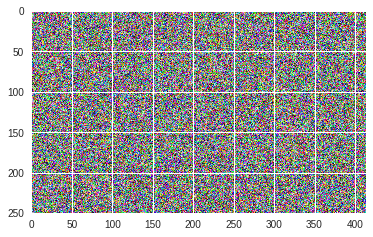

In [0]:
def rand_img(shape):
    return np.random.random(shape) * 20 + 128

x = rand_img(shp)
plt.imshow(x[0])
imsave('results/res_at_iteration_0.png', x[0])
x = vgg16.preprocess_input(x)

In [0]:
iterations=10

x = solve_image(evaluator, iterations, x)


Start of iteration 1
Current loss value: 3084737536.0
Iteration 1 completed in 2s
Start of iteration 2
Current loss value: 1656817536.0
Iteration 2 completed in 2s
Start of iteration 3
Current loss value: 1189394944.0
Iteration 3 completed in 2s
Start of iteration 4
Current loss value: 981486848.0
Iteration 4 completed in 2s
Start of iteration 5
Current loss value: 855343360.0
Iteration 5 completed in 2s
Start of iteration 6
Current loss value: 769626560.0
Iteration 6 completed in 2s
Start of iteration 7
Current loss value: 703980224.0
Iteration 7 completed in 2s
Start of iteration 8
Current loss value: 652789056.0
Iteration 8 completed in 2s
Start of iteration 9
Current loss value: 612421824.0
Iteration 9 completed in 2s
Start of iteration 10
Current loss value: 579503744.0
Iteration 10 completed in 2s


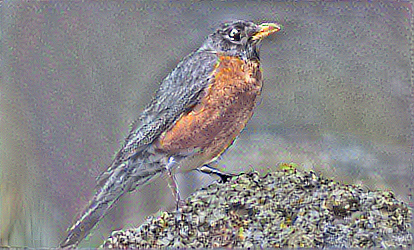

In [0]:
load_img(f'results/res_at_iteration_{iterations}.png')

In [0]:
def plot_images_labels(images, labels, height=15, idx=0, num=10):
    fig = plt.gcf()
    fig.set_size_inches(height, height*img_width // img_height)
    if num > 20: num = 20 
    for i in range(0, num):
        ax=plt.subplot(5, 3, i+1)
        ax.imshow(images[idx], cmap='binary')

        ax.set_title(f'{str(labels[idx])}', fontsize=10) 
        
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

In [0]:
images = []
labels = []
for i in range(iterations+1):
    img = load_img(f'results/res_at_iteration_{i}.png')
    images.append(np.array(img))
    labels.append(f'iteration_{i}')

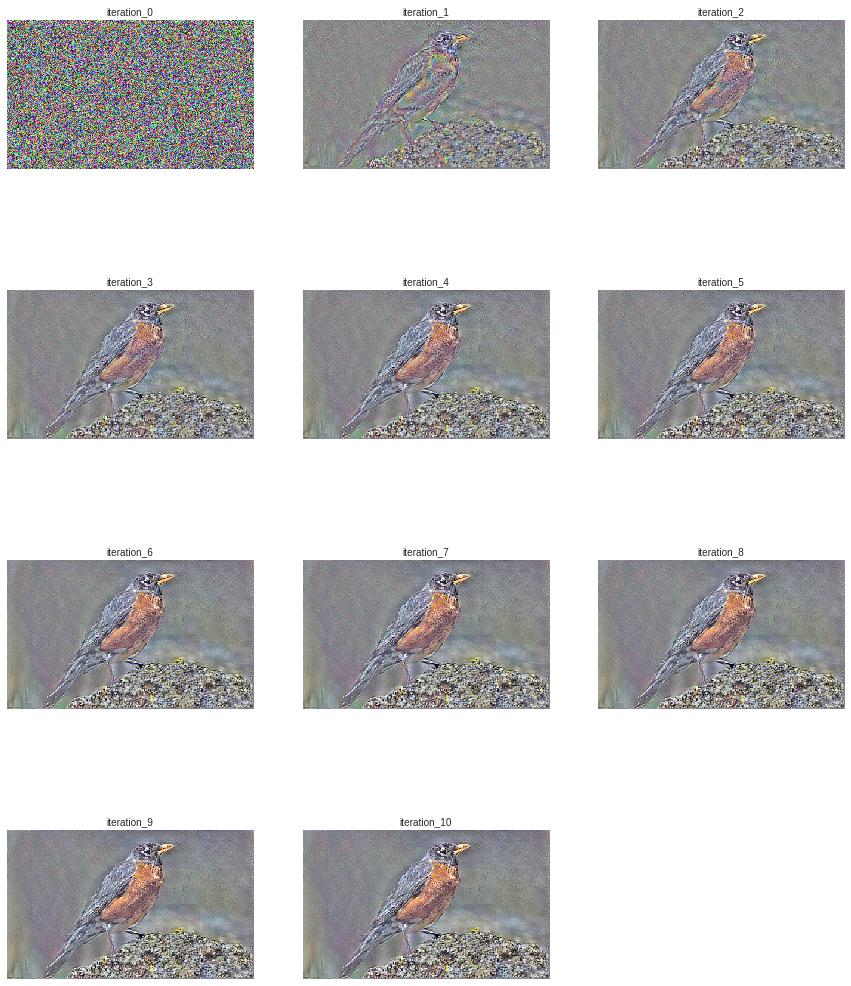

In [0]:
plot_images_labels(images, labels, num=iterations+1)


## Style Reconstructions

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def one_layer_style_loss(x, targ):
    S = gram_matrix(targ)
    C = gram_matrix(x)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layers used for style loss
style_layer_names = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1',
                     'block4_conv1',
                     'block5_conv1']

style_layers = [outputs_dict[l_name] for l_name in style_layer_names]

In [0]:
style_model = Model(model.input, style_layers)
targs = [K.constant(o) for o in style_model.predict(style_image_arr)]

In [0]:
style_loss = sum(one_layer_style_loss(l1[0], l2[0]) for l1,l2 in zip(style_layers, targs))
style_grads = K.gradients(style_loss, style_model.input)
style_fn = K.function([style_model.input], [style_loss]+style_grads)
style_evaluator = Evaluator(style_fn, shp)

In [0]:
x = rand_img(shp)
x = vgg16.preprocess_input(x)

In [0]:
x = solve_image(style_evaluator, iterations, x)

Start of iteration 1
Current loss value: 12323726336.0
Iteration 1 completed in 5s
Start of iteration 2
Current loss value: 2638018048.0
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 1036717056.0
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 563498112.0
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 350030656.0
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 258257072.0
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 203851408.0
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 168520624.0
Iteration 8 completed in 3s
Start of iteration 9
Current loss value: 143282656.0
Iteration 9 completed in 3s
Start of iteration 10
Current loss value: 123967520.0
Iteration 10 completed in 3s


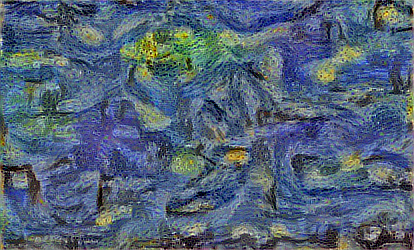

In [0]:
load_img(f'results/res_at_iteration_{iterations}.png')

$\alpha, \beta, \gamma$

In [0]:
iterations=10
alpha, beta = 0.2, 1. 

transfer_loss = alpha * (K.sum(K.square(content_layer - targ)) / 2)
transfer_loss += beta * (sum(one_layer_style_loss(l1[0], l2[0]) for l1,l2 in zip(style_layers, targs)))

transfer_grads = K.gradients(transfer_loss, model.input)
transfer_fn = K.function([model.input], [transfer_loss]+transfer_grads)

transfer_evaluator = Evaluator(transfer_fn, shp)

x = rand_img(shp)
x = vgg16.preprocess_input(x)

solve_image(transfer_evaluator, iterations, x)

Start of iteration 1
Current loss value: 16471618560.0
Iteration 1 completed in 5s
Start of iteration 2
Current loss value: 5251610624.0
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 3232114688.0
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 2384121856.0
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 1957853056.0
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 1738461440.0
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 1618948352.0
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 1527336192.0
Iteration 8 completed in 3s
Start of iteration 9
Current loss value: 1464626816.0
Iteration 9 completed in 3s
Start of iteration 10
Current loss value: 1415982080.0
Iteration 10 completed in 3s


array([57.52991294, 63.50404265, 27.49311964, ..., 32.55886466,
        5.12438666,  3.94502608])

alpha, beta = 0.2, 1.


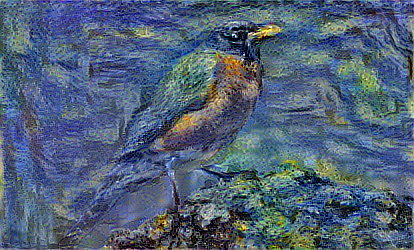

In [0]:
print('alpha, beta = 0.2, 1.')
load_img(f'results/res_at_iteration_{iterations}.png')

In [0]:
def generate_transfer_img(alpha=0.5, beta=1., iterations=10):

    transfer_loss = alpha * (K.sum(K.square(content_layer - targ)) / 2)
    transfer_loss += beta * (sum(one_layer_style_loss(l1[0], l2[0]) for l1,l2 in zip(style_layers, targs)))

    transfer_grads = K.gradients(transfer_loss, model.input)
    transfer_fn = K.function([model.input], [transfer_loss]+transfer_grads)

    transfer_evaluator = Evaluator(transfer_fn, shp)

    x = rand_img(shp)
    x = vgg16.preprocess_input(x)

    solve_image(transfer_evaluator, iterations, x)
    
    return iterations    

In [0]:
img_index = generate_transfer_img(0.4, 1, 10)

Start of iteration 1
Current loss value: 18277971968.0
Iteration 1 completed in 5s
Start of iteration 2
Current loss value: 6656551936.0
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 4106217984.0
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 3197184512.0
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 2755454976.0
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 2480748032.0
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 2312729344.0
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 2197773312.0
Iteration 8 completed in 3s
Start of iteration 9
Current loss value: 2117747200.0
Iteration 9 completed in 3s
Start of iteration 10
Current loss value: 2056319488.0
Iteration 10 completed in 3s


alpha, beta = 0.4, 1.


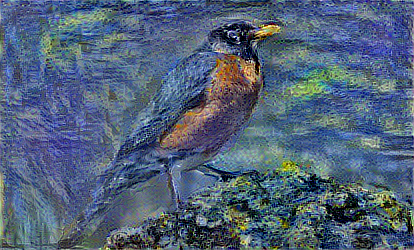

In [0]:
print('alpha, beta = 0.4, 1.')
load_img(f'results/res_at_iteration_{img_index}.png')

In [0]:
img_index = generate_transfer_img(0.6, 1, 10)

Start of iteration 1
Current loss value: 20798167040.0
Iteration 1 completed in 5s
Start of iteration 2
Current loss value: 7472332800.0
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 4759193600.0
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 3822530560.0
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 3351271424.0
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 3069087232.0
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 2896160768.0
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 2772586496.0
Iteration 8 completed in 3s
Start of iteration 9
Current loss value: 2680011264.0
Iteration 9 completed in 3s
Start of iteration 10
Current loss value: 2616557056.0
Iteration 10 completed in 3s


alpha, beta = 0.6, 1.


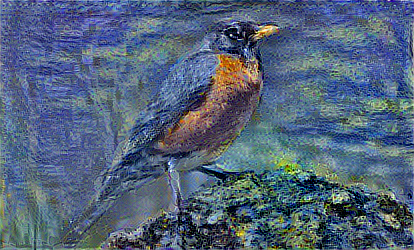

In [0]:
print('alpha, beta = 0.6, 1.')
load_img(f'results/res_at_iteration_{img_index}.png')